# Analysis of Longitudinal Change in PVC vc Non-PVC Data

In [1]:
using Pkg
Pkg.status()

Status `~/Projects/local-fkpp/Project.toml`
  [3276ce4d] ADNIDatasets v0.1.0 `https://github.com/PavanChaggar/ADNIDatasets.jl.git#main`
⌃ [0bf59076] AdvancedHMC v0.6.1
  [6e4b80f9] BenchmarkTools v1.5.0
  [336ed68f] CSV v0.10.14
  [55f7864d] Connectomes v0.1.0 `https://github.com/PavanChaggar/Connectomes.jl.git#main`
⌃ [a93c6f00] DataFrames v1.6.1
⌃ [0c46a032] DifferentialEquations v7.13.0
⌃ [31c24e10] Distributions v0.25.109
⌃ [634d3b9d] DrWatson v2.15.0
⌃ [e9467ef8] GLMakie v0.9.11
⌃ [86223c79] Graphs v1.11.1
⌃ [09f84164] HypothesisTests v0.11.0
⌃ [7073ff75] IJulia v1.24.2
⌃ [6fdf6af0] LogDensityProblems v2.1.1
⌃ [996a588d] LogDensityProblemsAD v1.9.0
  [c7f686f2] MCMCChains v6.0.6
  [429524aa] Optim v1.9.4
⌃ [1dea7af3] OrdinaryDiffEq v6.85.0
⌃ [43a3c2be] PairPlots v2.7.3
⌃ [b1d3bc72] Pathfinder v0.8.7
⌃ [91a5bcdd] Plots v1.40.4
⌃ [08abe8d2] PrettyTables v2.3.2
⌃ [1ed8b502] SciMLSensitivity v7.61.1
  [f3b207a7] StatsPlots v0.15.7
⌃ [337ecbd1] TidierPlots v0.7.6
⌃ [fce5fe82] Turing v0

In [ ]:
using ADNIDatasets
using Connectomes
using CSV, DataFrames
using DrWatson
using CairoMakie
include(projectdir("functions.jl"))

In [6]:
# Convenience functions for calculating longitudinal changes
function get_diff(x::Matrix{Float64})
    x[:,end] .- x[:,1]
end
function get_diff(x::Vector{Float64})
    x[end] - x[1]
end
cols = Makie.wong_colors();

## Analysis without PVC

In [67]:
include(projectdir("adni/inference/inference-preamble.jl")); # Load data
_abneg_data = ADNIDataset(negdf, dktnames; min_scans=3, reference_region="INFERIORCEREBELLUM", qc=true)
n_subjects = length(_abneg_data)

66

In [68]:
abneg_mtl_pos = filter(x -> regional_mean(_abneg_data, mtl, x) >= mtl_cutoff, 1:n_subjects)
abneg_neo_pos = filter(x -> regional_mean(_abneg_data, neo, x) >= neo_cutoff, 1:n_subjects)

abneg_tau_pos = findall(x -> x ∈ unique([abneg_mtl_pos; abneg_neo_pos]), 1:n_subjects)
abneg_tau_neg = findall(x -> x ∉ abneg_tau_pos, 1:n_subjects)

abneg_data = _abneg_data[abneg_tau_neg]

ADNI data set with 60 subjects and 204 scans.

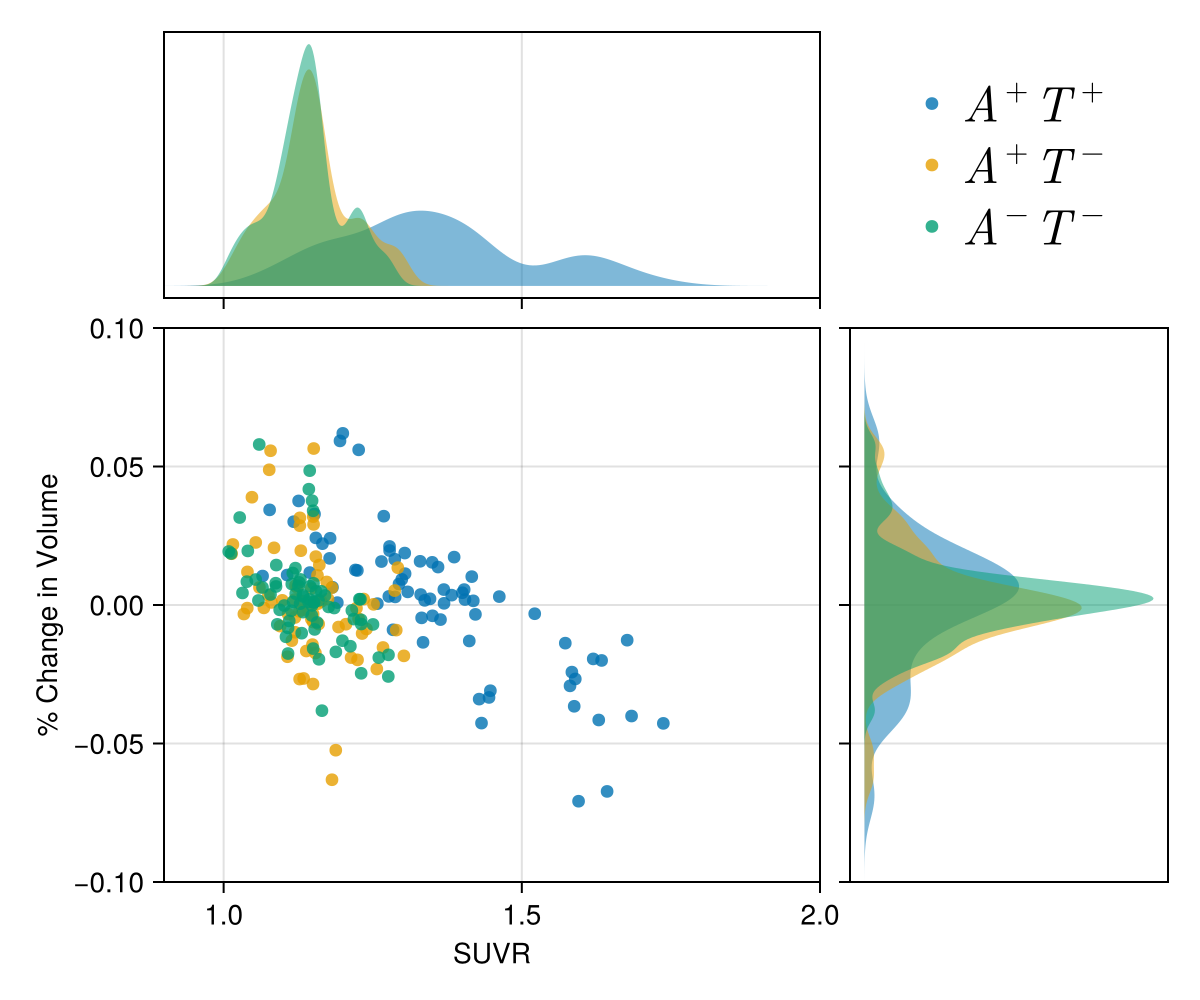

In [73]:
begin

    f = Figure(size=(600, 500))
    ax1 = Axis(f[2:3,1:2], xlabel="SUVR", ylabel="% Change in Volume")
    ylims!(ax1, -0.1, 0.1)
    xlims!(ax1, 0.9, 2.)

    ax2 = Axis(f[1,1:2])
    xlims!(ax2, 0.9, 2.)

    hidexdecorations!(ax2, ticks=false, grid=false)
    hideydecorations!(ax2, )

    ax3 = Axis(f[2:3,3])
    ylims!(ax3, -0.1, 0.1)
    hideydecorations!(ax3, ticks=false, grid=false)
    hidexdecorations!(ax3, )

    for (i, (d, label)) in enumerate(zip([pos_data, neg_data, abneg_data], [L"A^+T^+",L"A^+T^-",L"A^-T^-"]))

        subsuvr = calc_suvr.(d)
        subdata = [normalise(sd, u0, cc) for sd in subsuvr]

        # calculate volume data
        _vols = get_vol.(d)
        total_vol_norm = [tp ./ sum(tp, dims=1) for tp in _vols]
        vols = [(vol ./ vol[:,1]) for vol in total_vol_norm];

        scatter!(ax1, vec(mean(reduce(hcat, subdata), dims=2)), vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), color=(cols[i], 0.8),label=label)
        
        density!(ax2, vec(mean(reduce(hcat, subdata), dims=2)), color=(cols[i], 0.5))

        density!(ax3, vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), direction=:y, color=(cols[i], 0.5))
    end
    leg = Legend(f[1, 3], ax1, framevisible=false, tellwidth=false, labelsize=25)

    rowgap!(f.layout, 10)
    colgap!(f.layout, 10)
    f
end

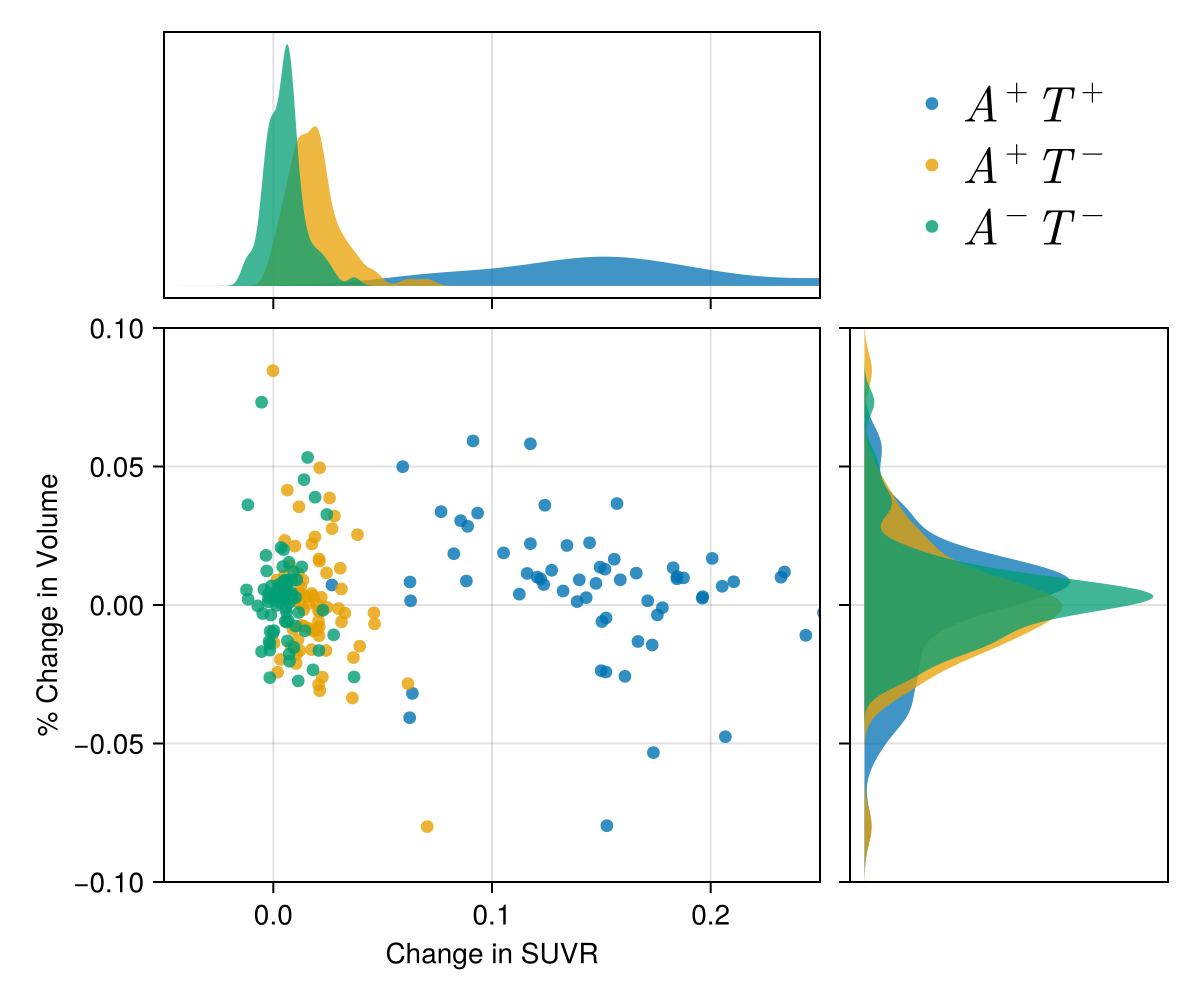

In [83]:
begin

    f = Figure(size=(600, 500))
    ax1 = Axis(f[2:3,1:2], xlabel="Change in SUVR", ylabel="% Change in Volume")
    ylims!(ax1, -0.1, 0.1)
    xlims!(ax1, -0.05, 0.25)

    ax2 = Axis(f[1,1:2])
    xlims!(ax2, -0.05, 0.25)
    hidexdecorations!(ax2, ticks=false, grid=false)
    hideydecorations!(ax2, )

    ax3 = Axis(f[2:3,3])
    ylims!(ax3, -0.1, 0.1)
    hideydecorations!(ax3, ticks=false, grid=false)
    hidexdecorations!(ax3, )

    for (i, (d, label)) in enumerate(zip([pos_data, neg_data, abneg_data], [L"A^+T^+",L"A^+T^-",L"A^-T^-"]))

        subsuvr = calc_suvr.(d)
        subdata = [normalise(sd, u0, cc) for sd in subsuvr]

        # calculate volume data
        _vols = get_vol.(d)
        total_vol_norm = [tp ./ sum(tp, dims=1) for tp in _vols]
        vols = [(vol ./ vol[:,1]) for vol in total_vol_norm];

        scatter!(ax1, vec(mean(reduce(hcat, get_diff.(subdata)), dims=2)), vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), color=(cols[i], 0.8), label=label)
        
        density!(ax2, vec(mean(reduce(hcat, get_diff.(subdata)), dims=2)), color=(cols[i], 0.75))

        density!(ax3, vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), direction=:y, color=(cols[i], 0.75))
    end
    leg = Legend(f[1, 3], ax1, framevisible=false, tellwidth=false, labelsize=25)
    rowgap!(f.layout, 10)
    colgap!(f.layout, 10)
    f
end

## Analysis with PVC

In [85]:
include(projectdir("adni/inference/local-fkpp/pvc/inference-preamble-pvc.jl"))

_abneg_data = ADNIDataset(negdf, dktnames; min_scans=3, reference_region="INFERIORCEREBELLUM", qc=true)
n_subjects = length(_abneg_data)

64

In [86]:
mtl_cutoff_pvc = mean(gmm_moments.cutoff[mtl])
neo_cutoff_pvc = mean(gmm_moments.cutoff[neo])

abneg_mtl_pos = filter(x -> regional_mean(_abneg_data, mtl, x) >= mtl_cutoff_pvc, 1:n_subjects)
abneg_neo_pos = filter(x -> regional_mean(_abneg_data, neo, x) >= neo_cutoff_pvc, 1:n_subjects)

abneg_tau_pos = findall(x -> x ∈ unique([abneg_mtl_pos; abneg_neo_pos]), 1:n_subjects)
abneg_tau_neg = findall(x -> x ∉ abneg_tau_pos, 1:n_subjects)

abneg_data = _abneg_data[abneg_tau_neg]

ADNI data set with 61 subjects and 208 scans.

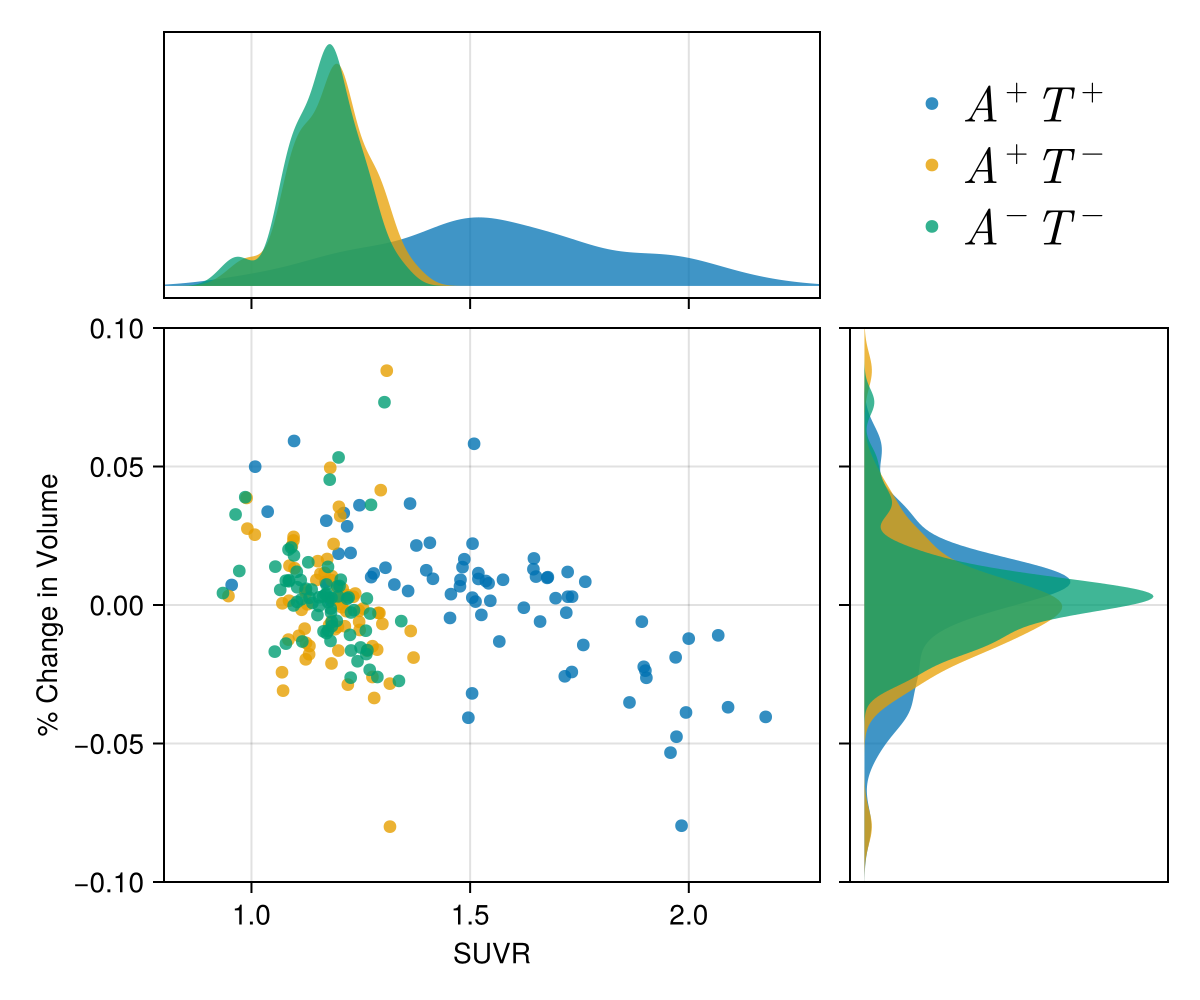

In [87]:
begin

    f = Figure(size=(600, 500))
    ax1 = Axis(f[2:3,1:2], xlabel="SUVR", ylabel="% Change in Volume")
    ylims!(ax1, -0.1, 0.1)
    xlims!(ax1, 0.8, 2.3)

    ax2 = Axis(f[1,1:2])
    xlims!(ax2, 0.8, 2.3)

    hidexdecorations!(ax2, ticks=false, grid=false)
    hideydecorations!(ax2, )

    ax3 = Axis(f[2:3,3])
    ylims!(ax3, -0.1, 0.1)
    hideydecorations!(ax3, ticks=false, grid=false)
    hidexdecorations!(ax3, )

    for (i, (d, label)) in enumerate(zip([pos_data, neg_data, abneg_data], [L"A^+T^+",L"A^+T^-",L"A^-T^-"]))

        subsuvr = calc_suvr.(d)
        subdata = [normalise(sd, u0, cc) for sd in subsuvr]

        # calculate volume data
        _vols = get_vol.(d)
        total_vol_norm = [tp ./ sum(tp, dims=1) for tp in _vols]
        vols = [(vol ./ vol[:,1]) for vol in total_vol_norm];

        scatter!(ax1, vec(mean(reduce(hcat, subdata), dims=2)), vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), color=(cols[i], 0.8),label=label)
        
        density!(ax2, vec(mean(reduce(hcat, subdata), dims=2)), color=(cols[i], 0.75))

        density!(ax3, vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), direction=:y, color=(cols[i], 0.75))
    end
    leg = Legend(f[1, 3], ax1, framevisible=false, tellwidth=false, labelsize=25)

    rowgap!(f.layout, 10)
    colgap!(f.layout, 10)
    f
end

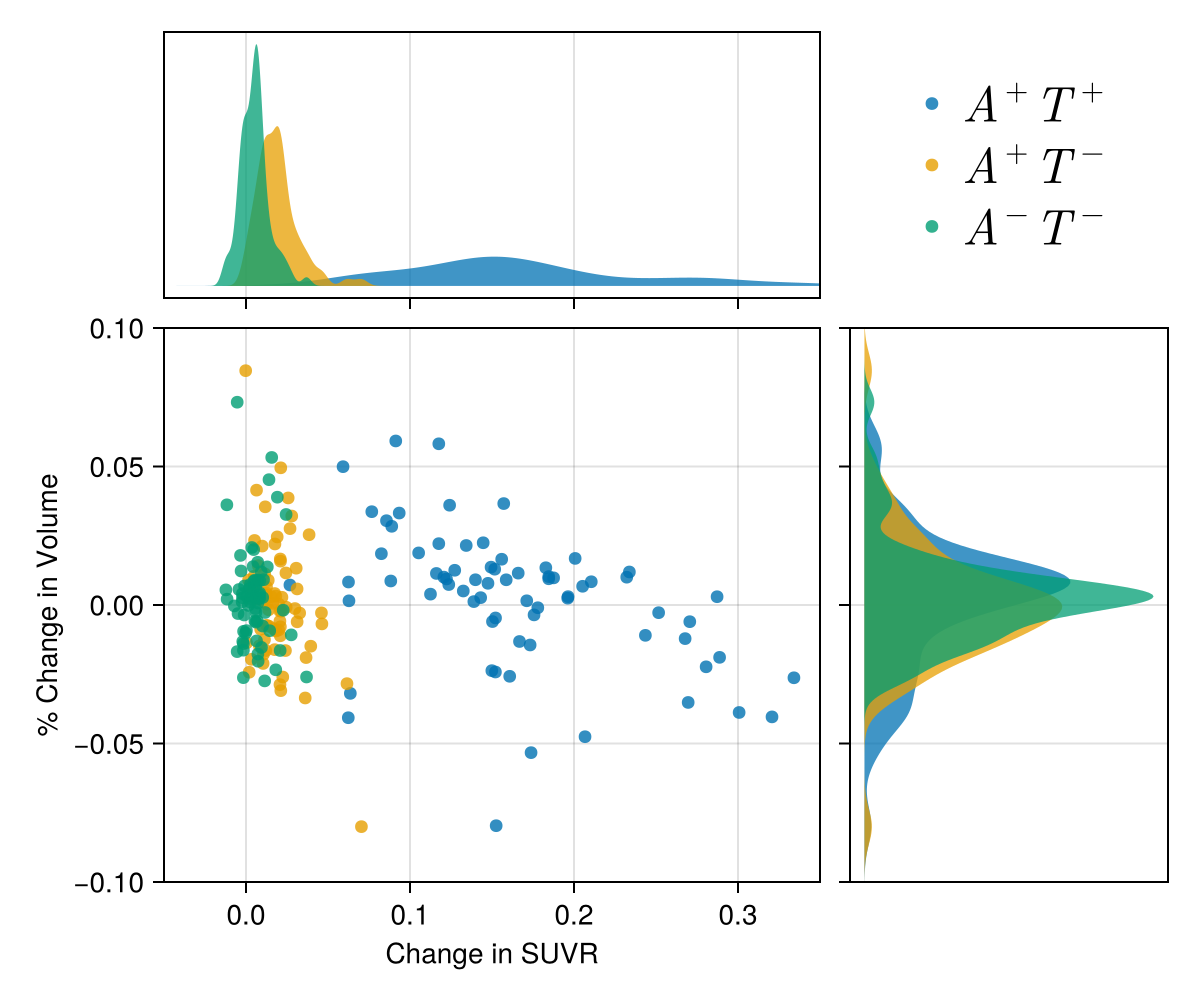

In [88]:
begin

    f = Figure(size=(600, 500))
    ax1 = Axis(f[2:3,1:2], xlabel="Change in SUVR", ylabel="% Change in Volume")
    ylims!(ax1, -0.1, 0.1)
    xlims!(ax1, -0.05, 0.35)

    ax2 = Axis(f[1,1:2])
    xlims!(ax2, -0.05, 0.35)
    hidexdecorations!(ax2, ticks=false, grid=false)
    hideydecorations!(ax2, )

    ax3 = Axis(f[2:3,3])
    ylims!(ax3, -0.1, 0.1)
    hideydecorations!(ax3, ticks=false, grid=false)
    hidexdecorations!(ax3, )

    for (i, (d, label)) in enumerate(zip([pos_data, neg_data, abneg_data], [L"A^+T^+",L"A^+T^-",L"A^-T^-"]))

        subsuvr = calc_suvr.(d)
        subdata = [normalise(sd, u0, cc) for sd in subsuvr]

        # calculate volume data
        _vols = get_vol.(d)
        total_vol_norm = [tp ./ sum(tp, dims=1) for tp in _vols]
        vols = [(vol ./ vol[:,1]) for vol in total_vol_norm];

        scatter!(ax1, vec(mean(reduce(hcat, get_diff.(subdata)), dims=2)), vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), color=(cols[i], 0.8), label=label)
        
        density!(ax2, vec(mean(reduce(hcat, get_diff.(subdata)), dims=2)), color=(cols[i], 0.75))

        density!(ax3, vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), direction=:y, color=(cols[i], 0.75))
    end
    leg = Legend(f[1, 3], ax1, framevisible=false, tellwidth=false, labelsize=25)
    rowgap!(f.layout, 10)
    colgap!(f.layout, 10)
    f
end